In [10]:
#import modules

import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.utils import multi_gpu_model
from keras.utils import Sequence
from keras.models import load_model
from tensorflow.distribute import MirroredStrategy

In [11]:
def LoadNewImages(TrainingPaths, ValidationPaths, TestPaths, NumberInSet):
    NumberImagesPerCrystal = 1
    #TrainingPaths = [[All training inputs], [All training outputs]]
    
    NewTrainingImages = np.zeros(NumberInSet[0] * NumberImagesPerCrystal * 128 * 128 * 2, dtype = np.float32).reshape(NumberInSet[0] * NumberImagesPerCrystal, 2, 128, 128)
    NewValidationImages = np.zeros(NumberInSet[1] * NumberImagesPerCrystal * 128 * 128 * 2, dtype = np.float32).reshape(NumberInSet[1] * NumberImagesPerCrystal, 2, 128, 128)
    NewTestImages = np.zeros(NumberInSet[2] * NumberImagesPerCrystal * 128 * 128 * 2, dtype = np.float32).reshape(NumberInSet[2] * NumberImagesPerCrystal, 2, 128, 128)
    
    
    for i in range(0, NumberInSet[0] * NumberImagesPerCrystal):
        NewTrainingImages[i][0] = np.load(TrainingPaths[0][i]).astype(np.float32)
        NewTrainingImages[i][1] = np.load(TrainingPaths[1][i]).astype(np.float32)
        
    for i in range(0, NumberInSet[1] * NumberImagesPerCrystal):
        NewValidationImages[i][0] = np.load(ValidationPaths[0][i]).astype(np.float32)
        NewValidationImages[i][1] = np.load(ValidationPaths[1][i]).astype(np.float32)
    
    for i in range(0, NumberInSet[2] * NumberImagesPerCrystal):
        NewTestImages[i][0] = np.load(TestPaths[0][i]).astype(np.float32)
        NewTestImages[i][1] = np.load(TestPaths[1][i]).astype(np.float32)
    
    AllNewImages = [NewTrainingImages, NewValidationImages, NewTestImages]
    return(AllNewImages)

def PairInputImages(All_Images): #Comparison done by a root mean square
    NumberImagesPerCrystal = 4
    #with All_Images = [Train_Images, Validation_Images, Test_Images]
    DataSetSize = [len(All_Images[0]), len(All_Images[1]), len(All_Images[2])] * NumberImagesPerCrystal
    TrainValidationPairs = np.zeros(DataSetSize[0] * DataSetSize[1], dtype = np.float32).reshape(DataSetSize[0], DataSetSize[1])
    TrainTestPairs = np.zeros(DataSetSize[0] * DataSetSize[2], dtype = np.float32).reshape(DataSetSize[0], DataSetSize[2])
    
    for i in range(0, DataSetSize[0]):
        print("1: ", i)
        for j in range(0, DataSetSize[1]):
            TrainValidationPairs[i][j] = MeanSquare(All_Images[0][i][0], All_Images[1][j][0])
            
    for i in range(0, DataSetSize[0]):
        print("2: ", i)
        for j in range(0, DataSetSize[2]):
            TrainTestPairs[i][j] = MeanSquare(All_Images[0][i][0], All_Images[2][j][0])
    
    BestPairTrainValidation = np.zeros(DataSetSize[1], dtype = np.int)
    BestPairTrainTest = np.zeros(DataSetSize[2], dtype = np.int)
    
    for i in range(0, DataSetSize[1]):
        print("3: ", i)
        min_val = np.inf
        for j in range(0, DataSetSize[0]):
            if(TrainValidationPairs[j][i] < min_val):
                BestPairTrainValidation[i] = j
                min_val = TrainValidationPairs[j][i]
                
    for i in range(0, DataSetSize[2]):
        print("4: ", i)
        min_val = np.inf
        for j in range(0, DataSetSize[0]):
            if(TrainTestPairs[j][i] < min_val):
                BestPairTrainTest[i] = j
                min_val = TrainTestPairs[j][i]
    return(BestPairTrainValidation, BestPairTrainTest)

def BestPairLoss(All_Images, BestPairTrainValidation, BestPairTrainTest):
    Val_Loss_Sum = 0
    Test_Loss_Sum = 0
    for i in range(0, len(BestPairTrainValidation)):
        Val_Loss_Sum+=MeanSquareLogError(All_Images[1][i][1], All_Images[0][BestPairTrainValidation[i]][1])
        print("1: ", i)
    for i in range(0, len(BestPairTrainTest)):
        Test_Loss_Sum+=MeanSquareLogError(All_Images[2][i][1], All_Images[0][BestPairTrainTest[i]][1])
        print("2: ", i)
    Val_Loss = Val_Loss_Sum / len(BestPairTrainValidation)
    Test_Loss = Test_Loss_Sum / len(BestPairTrainTest)
    return(Val_Loss, Test_Loss)

def MeanSquare(Image_1, Image_2): #Shape N by N
    ms = (np.sum(np.square(Image_1 - Image_2)))
    return(ms)

def MeanSquareLogError(Image_1, Image_2):
    msle = 0
    for i in range(0, len(Image_1)):
        for j in range(0, len(Image_1[i])):
            msle+=(math.log(1+Image_1[i][j]) - math.log(1+Image_2[i][j])) ** 2
    return(msle)

def JeremyFunc(NewTrainingPaths, NewValidationPaths, NewTestPaths):
    NumberInSet = [len(NewTrainingPaths[0]), len(NewValidationPaths[0]), len(NewTestPaths[0])]
    AllNewImages = LoadNewImages(NewTrainingPaths, NewValidationPaths, NewTestPaths, NumberInSet)
    BestPairTrainValidation, BestPairTrainTest = PairInputImages(AllNewImages)
    Val_Loss, Test_Loss = BestPairLoss(AllNewImages, BestPairTrainValidation, BestPairTrainTest)
    return(Val_Loss, Test_Loss)

In [12]:
#Define FelixDataflow classes and functions.

class FelixSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, file_type):
        """Here self.x is a list of paths to file_type files. self.y is a
        corresponding list of labels."""
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.file_type = file_type

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return arrs_from_paths(batch_x, self.file_type), to_categorical(np.array(batch_y),10)

def gen_paths_labels(base_path):
    """A generator to yield (data-paths, corresponding labels) tuples for each
    segment of data (typically training, validation, and testing)."""
    for segment in sorted(os.listdir(base_path)):
        segment_path = os.path.join(base_path, segment)
        segment_paths = []
        segment_labels = []
        for label in os.listdir(segment_path):
            label_path = os.path.join(segment_path, label)
            for crystal in os.listdir(label_path):
                segment_paths.append(os.path.join(label_path, crystal))
                segment_labels.append(label)
        indexes = np.arange(len(segment_labels))
        rng.shuffle(indexes)
        yield [np.array(segment_paths)[indexes], np.array(list(map(int,segment_labels)))[indexes]]

def arrs_from_paths(paths, file_type):
    if file_type == "txt":
        return np.array([np.loadtxt(file_name) for file_name in paths])
    elif file_type == "npy":
        #return np.array([np.load(file_name)[[0],:,:] for file_name in paths])
        return np.array([np.load(file_name) for file_name in paths])

  

In [13]:
def felix_fit_new(model, batch_size, epochs, workers, callbacks, AllPaths, file_type, train_history, val_history, patience, test_history, Monitor):
    #AllPaths = [[TrainingPaths, TrainingThickness], [], []]
    """A fit function to allow validation and test data to be supplied via a
    generator."""
    
    best_val_loss = np.inf
    best_val_acc = 0
    
    x = np.arange(0, epochs)
    
    train_seq = FelixSequence(AllPaths[0][0], AllPaths[0][1], batch_size, file_type)
    val_seq = FelixSequence(AllPaths[1][0], AllPaths[1][1], batch_size, file_type)
    test_seq = FelixSequence(AllPaths[2][0], AllPaths[2][1], batch_size, file_type)
    for epoch in range(epochs):
        print("-------------------------------------------------------------------------")
        print("Epoch", epoch+1, "/", epochs, ": ")
        print("Training: ")
        train_hist = model.fit(x = train_seq, epochs = epoch+1, workers = workers, initial_epoch = epoch, shuffle=True)
        train_history[0][epoch] = train_hist.history["loss"][0]
        train_history[1][epoch] = train_hist.history["acc"][0]
        print("Validation: ")
        val_hist = model.evaluate(x = val_seq, workers = workers, callbacks = callbacks)
        #print(val_hist)
        val_history[0][epoch] = val_hist[0]
        val_history[1][epoch] = val_hist[1]
        
        plt.plot(x, val_history[1])
        plt.show()
        
        epoch_loss = val_hist[0]
        epoch_acc = val_hist[1]
        
        
        if(Monitor == "loss"):
            if(epoch_loss < best_val_loss):
                model.save(NewPath+ModelName)
                print("The model loss improved from: ",best_val_loss, "to: ", epoch_loss)
                best_val_loss = epoch_loss
                patience_i = 0
            else:
                patience_i+=1
                print("The model did not improve, patience_i = ", patience_i)

            #val_hist[0][epoch] = avg_recon_loss
            if(patience_i > patience):
                print("Early Stopping, the model did not improve from a loss: ", best_val_loss)
                break
        
        elif(Monitor == "acc"):
            if(best_val_acc < epoch_acc):
                model.save(NewPath+ModelName)
                print("The model accuracy improved from: ",best_val_acc, "to: ", epoch_acc)
                best_val_acc = epoch_acc
                patience_i = 0
            else:
                patience_i+=1
                print("The model accuracy did not improve, patience_i = ", patience_i)

            #val_hist[0][epoch] = avg_recon_loss
            if(patience_i > patience):
                print("Early Stopping, the model did not improve from an accuracy: ", best_val_loss)
                break

    print("-------------------------------------------------------------------------")
    print("Testing: ")
    tst_hist = model.evaluate(test_seq)
    test_history[0] = tst_hist[0]
    test_history[1] = tst_hist[1]



In [63]:
#All paths

SaveDataPath = "/home/ug-ml/Documents/GitHub_BigFiles/SaveFolder" #Base directory of place you store information of models
SaveFolderName = "/Classifer_1_Scaling1" #Will create a folder and put in information about the outcome / inputs
ModelName = "/Model.hdf5"


#Many variables

#Model Variables
input_shape = (1, 128, 128)

#Hyper parameters
learning_rate = 0.0005
l2_regularizer = 0.0001
loss = 'categorical_crossentropy'
optimizer = "RMSprop" #Not a variable ONLY used for a note
batch_size = 16
epochs = 50
ShuffleTrainData = True

#Call back variables
TrainingPatience = 5
CheckPointMonitor = 'val_acc'
EarlyStopMonitor = 'val_acc'

#CPU variables
CPUworkers = 16


#List the name of the variables you want to save in a file
VariableListName = ["input_shape", 
                   "learning_rate", "l2_regularizer", "loss", "optimizer", "batch_size", "epochs", "ShuffleTrainData",
                   "TrainingPatience", "CheckPointMonitor", "EarlyStopMonitor",
                   "CPUworkers"]

#List the variables in the same order as VariableListName
VariableListValues = [input_shape, 
                   learning_rate, l2_regularizer, loss, optimizer, batch_size, epochs, ShuffleTrainData,
                   TrainingPatience, CheckPointMonitor, EarlyStopMonitor,
                   CPUworkers]

In [15]:
#Early stopping and check points

EarlyStop = EarlyStopping(monitor = EarlyStopMonitor,
                          mode = 'min',
                          verbose = 1,
                          patience = TrainingPatience)

NewPath = SaveDataPath + SaveFolderName
Checkpoint = ModelCheckpoint(NewPath + ModelName, #Save path
                             monitor = CheckPointMonitor,
                             verbose = 1,
                             save_best_only = True,
                             mode = 'auto',
                             save_freq = 'epoch')


#Make folder to put model and history information
try:
    os.mkdir(NewPath)
except:
    print("Folder failed to be created, it may already exist")
    
File1  = open(NewPath +"/Parameters.txt", "w+")
if(len(VariableListName) == len(VariableListValues)):
    for i in range(0, len(VariableListName)):
        File1.write(VariableListName[i] + " " + str(VariableListValues[i]) + "\n")
    File1.close()
else:
    print("VariableListName and VariableListValues do not match up, so file can not be saved")


Folder failed to be created, it may already exist


In [44]:
#Build model
#strategy = MirroredStrategy() #Allows multiple GPUs

#with strategy.scope():
    
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(48 * 1, (4, 4),
                                     activation='relu',
                                     data_format='channels_first',
                                     input_shape= input_shape))
    model.add(layers.MaxPooling2D((2, 2), data_format='channels_first'))
    model.add(layers.Conv2D(48 * 1, (4, 4),
                                     data_format='channels_first',
                                     activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), data_format='channels_first'))
    model.add(layers.Conv2D(48 * 1, (4, 4),
                                     data_format='channels_first',
                                     activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), data_format='channels_first'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(48 * 3, activation='relu',
                           kernel_regularizer = l2(l2_regularizer)))
    
    model.add(layers.Dense(10, activation='softmax',
                           kernel_regularizer = l2(l2_regularizer)))

    model.compile(loss = loss,
                  optimizer = optimizers.RMSprop(learning_rate = learning_rate),
                  metrics=['acc'])
    return model

#Save summary of model
#with open(NewPath + '/summary.txt','w') as fh:
#    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
#model.summary()

In [25]:
def MakeThicknessList(ListPaths):
    Thickness = []
    for i in ListPaths:
        Thickness.append(int(i.split("/")[-1].split(".")[0]))
    Thickness = np.array(Thickness)
    return(Thickness)

def OpenTxt(Path):
    with open(Path) as textFile:
        lines = [line.split() for line in textFile]
    List = []
    for i in lines:
        List.append(i[0])
    return(List)

DataPath = "/home/ug-ml/felix-ML/classification/Classification000/DataPaths/"

TrainPath = np.array(OpenTxt(DataPath + "Train_0p1.txt"), dtype="object")
ValPath = np.array(OpenTxt(DataPath + "Validation_0p1.txt"), dtype="object")
TestPath = np.array(OpenTxt(DataPath + "Test_0p1.txt"), dtype="object")

TrainThickness = np.array(MakeThicknessList(TrainPath))
ValThickness = np.array(MakeThicknessList(ValPath))
TestThickness = np.array(MakeThicknessList(TestPath))

#AllPaths = [[TrainPath,TrainThickness],[ValPath,ValThickness],[TestPath,TestThickness]]

In [41]:
fractions = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0]

train_len = TrainPath.size
val_len = ValPath.size
test_len = TestPath.size

num_train = int(train_len/9)
num_val = int(val_len/9)
num_test = int(test_len/9)

tmp_train_indexes = np.arange(0, int(num_train))*9
tmp_val_indexes = np.arange(0, int(num_val))*9
tmp_test_indexes = np.arange(0, int(num_test))*9

np.random.shuffle(tmp_train_indexes)
np.random.shuffle(tmp_val_indexes)
np.random.shuffle(tmp_test_indexes)

train_indexes = np.empty(shape=train_len)
val_indexes = np.empty(shape=val_len)
test_indexes = np.empty(shape=test_len)

for i, idx in enumerate(tmp_train_indexes):
    for j in range(0,9):
        train_indexes[i*9+j] = idx+j
    
for i, idx in enumerate(tmp_val_indexes):
    for j in range(0,9):
        val_indexes[i*9+j] = idx+j
    
for i, idx in enumerate(tmp_test_indexes):
    for j in range(0,9):
        test_indexes[i*9+j] = idx+j

    
print(train_indexes)
print(test_indexes)


#np.random.shuffle(train_indexes)
#np.random.shuffle(val_indexes)
#np.random.shuffle(test_indexes)
#print(train_len, val_len, test_len)



[18972. 18973. 18974. ... 27321. 27322. 27323.]
[ 891.  892.  893. ... 1545. 1546. 1547.]


In [60]:
np.save("train_indexes", train_indexes)
np.save("val_indexes", val_indexes)
np.save("test_indexes", test_indexes)



In [52]:
#vae = models.load_model("/home/ug-ml/felix-ML/VAE_000/Data/Models/VAE_3")
batch_size=32
epochs = 1500
patience = 10
workers = 16
Monitor = "acc"
best_model_name = "VAE_Reduced_J1_V2"
test_history=np.zeros(shape=(2, len(fractions)*3))
frac_c = 0
for frac in fractions:
    print("Data frac:", frac)
    #training and validation histories, containing [0] the total loss, [1] the reconstruction loss, and [2] the kl loss.
    val_hist = np.zeros(shape=(3,1,epochs))
    train_hist = np.zeros(shape=(3,3,epochs))
    james_hist = np.zeros(shape=(3,2))
    for run in range(3):
        print(train_indexes[:int(num_train*frac)*9].astype(int))
        wrk_train_in = TrainPath[train_indexes[:int(num_train*frac)*9].astype(int)]
        wrk_train_out = TrainThickness[train_indexes[:int(num_train*frac)*9].astype(int)]

        wrk_val_in = ValPath[val_indexes[:int(num_val*frac)*9].astype(int)]
        wrk_val_out = ValThickness[val_indexes[:int(num_val*frac)*9].astype(int)]

        wrk_test_in = TestPath[test_indexes[:int(num_test*frac)*9].astype(int)]
        wrk_test_out = TestThickness[test_indexes[:int(num_test*frac)*9].astype(int)]
        
        print(wrk_train_in.size, wrk_val_in.size, wrk_test_in.size)
       
        
        #james_hist[run][0], james_hist[run][1] = JeremyFunc([wrk_train_in, wrk_train_out], 
        #                                                    [wrk_val_in, wrk_val_out], 
        #                                                    [wrk_test_in, wrk_test_out])


        model = build_model()


        train_seq = FelixSequence(wrk_train_in, wrk_train_out, batch_size, "npy")
        val_seq = FelixSequence(wrk_val_in, wrk_val_out, batch_size, "npy")
        test_seq = FelixSequence(wrk_test_in, wrk_test_out, batch_size, "npy")
        
        best_val_loss = np.inf
        best_val_acc = 0

        x = np.arange(0, epochs)

        for epoch in range(epochs):
            print("-------------------------------------------------------------------------")
            print("Epoch", epoch+1, "/", epochs, ": ")
            print("Training: ")
            train_hist = model.fit(x = train_seq, epochs = epoch+1, workers = workers, initial_epoch = epoch, shuffle=True)
            #train_history[0][epoch] = train_hist.history["loss"][0]
            #train_history[1][epoch] = train_hist.history["acc"][0]
            print("Validation: ")
            val_hist = model.evaluate(x = val_seq, workers = workers)
            #print(val_hist)
            #val_history[0][epoch] = val_hist[0]
            #val_history[1][epoch] = val_hist[1]

            #plt.plot(x, val_history[1])
            #plt.show()

            epoch_loss = val_hist[0]
            epoch_acc = val_hist[1]


            if(Monitor == "loss"):
                if(epoch_loss < best_val_loss):
                    model.save(NewPath+ModelName)
                    print("The model loss improved from: ",best_val_loss, "to: ", epoch_loss)
                    best_val_loss = epoch_loss
                    patience_i = 0
                else:
                    patience_i+=1
                    print("The model did not improve, patience_i = ", patience_i)

                #val_hist[0][epoch] = avg_recon_loss
                if(patience_i > patience):
                    print("Early Stopping, the model did not improve from a loss: ", best_val_loss)
                    break

            elif(Monitor == "acc"):
                if(best_val_acc < epoch_acc):
                    model.save(NewPath+ModelName)
                    print("The model accuracy improved from: ",best_val_acc, "to: ", epoch_acc)
                    best_val_acc = epoch_acc
                    patience_i = 0
                else:
                    patience_i+=1
                    print("The model accuracy did not improve, patience_i = ", patience_i)

                #val_hist[0][epoch] = avg_recon_loss
                if(patience_i > patience):
                    print("Early Stopping, the model did not improve from an accuracy: ", best_val_loss)
                    break

        print("-------------------------------------------------------------------------")
        print("Testing: ")
        tst_hist = model.evaluate(test_seq)
        test_history[0][frac_c] = tst_hist[0]
        test_history[1][frac_c] = tst_hist[1]
    
    frac_c += 1


Data frac: 0.1
[18972 18973 18974 ... 39597 39598 39599]
5652 657 333
-------------------------------------------------------------------------
Epoch 1 / 1500 : 
Training: 
177/177 [==============================] - 6s 36ms/step - loss: 2.0617 - acc: 0.2059
Validation: 
21/21 [==============================] - 0s 18ms/step - loss: 2.3100 - acc: 0.2009
The model accuracy improved from:  0 to:  0.2009132355451584
-------------------------------------------------------------------------
Epoch 2 / 1500 : 
Training: 
Epoch 2/2
177/177 [==============================] - 6s 32ms/step - loss: 1.8872 - acc: 0.2840
Validation: 
21/21 [==============================] - 0s 20ms/step - loss: 1.9191 - acc: 0.2679
The model accuracy improved from:  0.2009132355451584 to:  0.2678843140602112
-------------------------------------------------------------------------
Epoch 3 / 1500 : 
Training: 
Epoch 3/3
177/177 [==============================] - 6s 31ms/step - loss: 1.7705 - acc: 0.3349
Validation: 
21

Epoch 23/23
177/177 [==============================] - 6s 35ms/step - loss: 0.4782 - acc: 0.8615
Validation: 
21/21 [==============================] - 1s 24ms/step - loss: 3.1383 - acc: 0.4658
The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 24 / 1500 : 
Training: 
Epoch 24/24
177/177 [==============================] - 7s 39ms/step - loss: 0.4518 - acc: 0.8740
Validation: 
21/21 [==============================] - 0s 20ms/step - loss: 3.0930 - acc: 0.4779
The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 25 / 1500 : 
Training: 
Epoch 25/25
177/177 [==============================] - 7s 38ms/step - loss: 0.4304 - acc: 0.8861
Validation: 
21/21 [==============================] - 0s 21ms/step - loss: 3.1491 - acc: 0.4871
The model accuracy did not improve, patience_i =  4
---------------------------------------------------------

177/177 [==============================] - 6s 32ms/step - loss: 0.2008 - acc: 0.9671
Validation: 
21/21 [==============================] - 1s 25ms/step - loss: 4.8998 - acc: 0.4825
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 47 / 1500 : 
Training: 
Epoch 47/47
177/177 [==============================] - 7s 39ms/step - loss: 0.2198 - acc: 0.9636
Validation: 
21/21 [==============================] - 0s 23ms/step - loss: 4.8053 - acc: 0.5053
The model accuracy improved from:  0.5022830963134766 to:  0.5053272247314453
-------------------------------------------------------------------------
Epoch 48 / 1500 : 
Training: 
Epoch 48/48
177/177 [==============================] - 6s 36ms/step - loss: 0.1968 - acc: 0.9705
Validation: 
21/21 [==============================] - 0s 24ms/step - loss: 5.0188 - acc: 0.4871
The model accuracy did not improve, patience_i =  1
-------------------------------------------

Epoch 10/10
177/177 [==============================] - 7s 38ms/step - loss: 1.0911 - acc: 0.6221
Validation: 
21/21 [==============================] - 0s 18ms/step - loss: 1.9324 - acc: 0.4170
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 11 / 1500 : 
Training: 
Epoch 11/11
177/177 [==============================] - 6s 31ms/step - loss: 1.0154 - acc: 0.6532
Validation: 
21/21 [==============================] - 0s 22ms/step - loss: 1.8526 - acc: 0.4307
The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 12 / 1500 : 
Training: 
Epoch 12/12
177/177 [==============================] - 6s 34ms/step - loss: 0.9401 - acc: 0.6840
Validation: 
21/21 [==============================] - 0s 20ms/step - loss: 2.0077 - acc: 0.4475
The model accuracy did not improve, patience_i =  3
---------------------------------------------------------

Validation: 
21/21 [==============================] - 1s 25ms/step - loss: 1.7323 - acc: 0.3653
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 7 / 1500 : 
Training: 
Epoch 7/7
177/177 [==============================] - 7s 40ms/step - loss: 1.4409 - acc: 0.4804
Validation: 
21/21 [==============================] - 0s 23ms/step - loss: 1.8009 - acc: 0.3775
The model accuracy improved from:  0.3652968108654022 to:  0.3774733543395996
-------------------------------------------------------------------------
Epoch 8 / 1500 : 
Training: 
Epoch 8/8
177/177 [==============================] - 6s 32ms/step - loss: 1.3505 - acc: 0.5149
Validation: 
21/21 [==============================] - 0s 14ms/step - loss: 1.6838 - acc: 0.4186
The model accuracy improved from:  0.3774733543395996 to:  0.41856926679611206
-------------------------------------------------------------------------
Epoch 9 / 1500 : 
Training: 
Epoc

177/177 [==============================] - 7s 38ms/step - loss: 0.3362 - acc: 0.9193
Validation: 
21/21 [==============================] - 0s 16ms/step - loss: 3.6310 - acc: 0.5008
The model accuracy improved from:  0.4992389678955078 to:  0.5007610321044922
-------------------------------------------------------------------------
Epoch 30 / 1500 : 
Training: 
Epoch 30/30
177/177 [==============================] - 7s 39ms/step - loss: 0.3265 - acc: 0.9195
Validation: 
21/21 [==============================] - 0s 20ms/step - loss: 4.1149 - acc: 0.4855
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 31 / 1500 : 
Training: 
Epoch 31/31
177/177 [==============================] - 7s 39ms/step - loss: 0.3021 - acc: 0.9260
Validation: 
21/21 [==============================] - 0s 19ms/step - loss: 3.8934 - acc: 0.4795
The model accuracy did not improve, patience_i =  2
-------------------------------------------

42/42 [==============================] - 1s 31ms/step - loss: 1.6040 - acc: 0.4187
The model accuracy improved from:  0.3771730959415436 to:  0.4187452793121338
-------------------------------------------------------------------------
Epoch 5 / 1500 : 
Training: 
Epoch 5/5
354/354 [==============================] - 14s 40ms/step - loss: 1.3478 - acc: 0.5305
Validation: 
42/42 [==============================] - 1s 34ms/step - loss: 1.6060 - acc: 0.4263
The model accuracy improved from:  0.4187452793121338 to:  0.4263038635253906
-------------------------------------------------------------------------
Epoch 6 / 1500 : 
Training: 
Epoch 6/6
354/354 [==============================] - 11s 31ms/step - loss: 1.2447 - acc: 0.5698 0s - loss: 1.2392 - acc: 0.57 - ETA: 0s - loss: 1.2443 - acc: 0.5 - ETA: 0s - loss: 1.2442 - 
Validation: 
42/42 [==============================] - 1s 30ms/step - loss: 1.5491 - acc: 0.4664
The model accuracy improved from:  0.4263038635253906 to:  0.466364324092865


354/354 [==============================] - 12s 34ms/step - loss: 0.3548 - acc: 0.9246
Validation: 
42/42 [==============================] - 1s 33ms/step - loss: 2.6255 - acc: 0.5654
The model accuracy did not improve, patience_i =  7
-------------------------------------------------------------------------
Epoch 27 / 1500 : 
Training: 
Epoch 27/27
354/354 [==============================] - 13s 37ms/step - loss: 0.3463 - acc: 0.9276
Validation: 
42/42 [==============================] - 1s 35ms/step - loss: 2.9490 - acc: 0.5684
The model accuracy did not improve, patience_i =  8
-------------------------------------------------------------------------
Epoch 28 / 1500 : 
Training: 
Epoch 28/28
354/354 [==============================] - 13s 38ms/step - loss: 0.3310 - acc: 0.9352
Validation: 
42/42 [==============================] - 1s 33ms/step - loss: 2.8489 - acc: 0.5722
The model accuracy did not improve, patience_i =  9
------------------------------------------------------------------

Epoch 18/18
354/354 [==============================] - 12s 32ms/step - loss: 0.5021 - acc: 0.8689
Validation: 
42/42 [==============================] - 1s 29ms/step - loss: 2.4059 - acc: 0.5374
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 19 / 1500 : 
Training: 
Epoch 19/19
354/354 [==============================] - 13s 36ms/step - loss: 0.4491 - acc: 0.8848
Validation: 
42/42 [==============================] - 1s 33ms/step - loss: 2.4285 - acc: 0.5344: 0s - loss: 2.3803 
The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 20 / 1500 : 
Training: 
Epoch 20/20
354/354 [==============================] - 14s 39ms/step - loss: 0.4559 - acc: 0.8907
Validation: 
42/42 [==============================] - 1s 31ms/step - loss: 2.2786 - acc: 0.5503
The model accuracy did not improve, patience_i =  3
----------------------------------

354/354 [==============================] - 13s 37ms/step - loss: 1.4805 - acc: 0.4673
Validation: 
42/42 [==============================] - 1s 32ms/step - loss: 1.6480 - acc: 0.4074
The model accuracy improved from:  0.3643234968185425 to:  0.40740740299224854
-------------------------------------------------------------------------
Epoch 5 / 1500 : 
Training: 
Epoch 5/5
354/354 [==============================] - 13s 37ms/step - loss: 1.3650 - acc: 0.5122
Validation: 
42/42 [==============================] - 1s 32ms/step - loss: 1.6558 - acc: 0.4248
The model accuracy improved from:  0.40740740299224854 to:  0.4247921407222748
-------------------------------------------------------------------------
Epoch 6 / 1500 : 
Training: 
Epoch 6/6
354/354 [==============================] - 14s 40ms/step - loss: 1.2802 - acc: 0.5510
Validation: 
42/42 [==============================] - 1s 33ms/step - loss: 1.5187 - acc: 0.4618
The model accuracy improved from:  0.4247921407222748 to:  0.461829185

42/42 [==============================] - 1s 30ms/step - loss: 2.4733 - acc: 0.5684
The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 27 / 1500 : 
Training: 
Epoch 27/27
354/354 [==============================] - 14s 39ms/step - loss: 0.3579 - acc: 0.9223
Validation: 
42/42 [==============================] - 1s 31ms/step - loss: 2.5744 - acc: 0.5646
The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Epoch 28 / 1500 : 
Training: 
Epoch 28/28
354/354 [==============================] - 13s 38ms/step - loss: 0.3553 - acc: 0.9220 1s - loss: 0.35
Validation: 
42/42 [==============================] - 1s 33ms/step - loss: 2.5025 - acc: 0.5586
The model accuracy did not improve, patience_i =  7
-------------------------------------------------------------------------
Epoch 29 / 1500 : 
Training: 
Epoch 29/29
354/354 [========================

354/354 [==============================] - 14s 40ms/step - loss: 0.2236 - acc: 0.9648
Validation: 
42/42 [==============================] - 1s 32ms/step - loss: 3.6728 - acc: 0.5639
The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 50 / 1500 : 
Training: 
Epoch 50/50
354/354 [==============================] - 14s 40ms/step - loss: 0.2205 - acc: 0.9672
Validation: 
42/42 [==============================] - 1s 30ms/step - loss: 3.6827 - acc: 0.5865
The model accuracy improved from:  0.5759637355804443 to:  0.5865457057952881
-------------------------------------------------------------------------
Epoch 51 / 1500 : 
Training: 
Epoch 51/51
354/354 [==============================] - 14s 41ms/step - loss: 0.2939 - acc: 0.9659
Validation: 
42/42 [==============================] - 1s 30ms/step - loss: 3.4465 - acc: 0.5752
The model accuracy did not improve, patience_i =  1
----------------------------------------

708/708 [==============================] - 29s 40ms/step - loss: 0.8876 - acc: 0.7191
Validation: 
83/83 [==============================] - 3s 31ms/step - loss: 1.4010 - acc: 0.5974
The model accuracy improved from:  0.5924670696258545 to:  0.5973634719848633
-------------------------------------------------------------------------
Epoch 11 / 1500 : 
Training: 
Epoch 11/11
708/708 [==============================] - 28s 39ms/step - loss: 0.8341 - acc: 0.7425
Validation: 
83/83 [==============================] - 3s 37ms/step - loss: 1.2792 - acc: 0.6154
The model accuracy improved from:  0.5973634719848633 to:  0.6154425740242004
-------------------------------------------------------------------------
Epoch 12 / 1500 : 
Training: 
Epoch 12/12
708/708 [==============================] - 24s 35ms/step - loss: 0.7804 - acc: 0.7626
Validation: 
83/83 [==============================] - 3s 35ms/step - loss: 1.3642 - acc: 0.6218
The model accuracy improved from:  0.6154425740242004 to:  0.62184

Epoch 33/33
708/708 [==============================] - 28s 40ms/step - loss: 0.3790 - acc: 0.9263
Validation: 
83/83 [==============================] - 3s 36ms/step - loss: 1.9022 - acc: 0.6678
The model accuracy improved from:  0.6632768511772156 to:  0.6677966117858887
-------------------------------------------------------------------------
Epoch 34 / 1500 : 
Training: 
Epoch 34/34
708/708 [==============================] - 29s 40ms/step - loss: 0.3753 - acc: 0.9277
Validation: 
83/83 [==============================] - 3s 39ms/step - loss: 1.9567 - acc: 0.6614: 1s
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 35 / 1500 : 
Training: 
Epoch 35/35
708/708 [==============================] - 28s 40ms/step - loss: 0.3608 - acc: 0.9294 2s -  - ETA: 0s - loss: 0.3592 - acc: 
Validation: 
83/83 [==============================] - 3s 35ms/step - loss: 2.0570 - acc: 0.6561
The model accuracy did not improve, p

708/708 [==============================] - 27s 38ms/step - loss: 0.8790 - acc: 0.7234
Validation: 
83/83 [==============================] - 3s 37ms/step - loss: 1.3067 - acc: 0.6049
The model accuracy improved from:  0.5890772342681885 to:  0.6048964262008667
-------------------------------------------------------------------------
Epoch 11 / 1500 : 
Training: 
Epoch 11/11
708/708 [==============================] - 28s 40ms/step - loss: 0.8319 - acc: 0.7433
Validation: 
83/83 [==============================] - 3s 34ms/step - loss: 1.3693 - acc: 0.6026
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 12 / 1500 : 
Training: 
Epoch 12/12
708/708 [==============================] - 29s 42ms/step - loss: 0.7778 - acc: 0.7650
Validation: 
83/83 [==============================] - 3s 39ms/step - loss: 1.2892 - acc: 0.6222
The model accuracy improved from:  0.6048964262008667 to:  0.6222222447395325
--------------

Epoch 33/33
708/708 [==============================] - 29s 41ms/step - loss: 0.3673 - acc: 0.9295
Validation: 
83/83 [==============================] - 3s 39ms/step - loss: 2.3185 - acc: 0.6659
The model accuracy did not improve, patience_i =  8
-------------------------------------------------------------------------
Epoch 34 / 1500 : 
Training: 
Epoch 34/34
708/708 [==============================] - 29s 40ms/step - loss: 0.3577 - acc: 0.9319
Validation: 
83/83 [==============================] - 3s 38ms/step - loss: 1.9983 - acc: 0.6606
The model accuracy did not improve, patience_i =  9
-------------------------------------------------------------------------
Epoch 35 / 1500 : 
Training: 
Epoch 35/35
708/708 [==============================] - 24s 34ms/step - loss: 0.3719 - acc: 0.9328
Validation: 
83/83 [==============================] - 3s 38ms/step - loss: 2.3348 - acc: 0.6655
The model accuracy did not improve, patience_i =  10
-----------------------------------------------------

Epoch 19/19
708/708 [==============================] - 28s 40ms/step - loss: 0.5387 - acc: 0.8631 2s
Validation: 
83/83 [==============================] - 3s 31ms/step - loss: 1.6922 - acc: 0.6437
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 20 / 1500 : 
Training: 
Epoch 20/20
708/708 [==============================] - 28s 40ms/step - loss: 0.5207 - acc: 0.8698
Validation: 
83/83 [==============================] - 3s 33ms/step - loss: 1.6853 - acc: 0.6637
The model accuracy improved from:  0.6500941514968872 to:  0.6636534929275513
-------------------------------------------------------------------------
Epoch 21 / 1500 : 
Training: 
Epoch 21/21
708/708 [==============================] - 29s 42ms/step - loss: 0.5027 - acc: 0.8756
Validation: 
83/83 [==============================] - 3s 37ms/step - loss: 1.7895 - acc: 0.6441
The model accuracy did not improve, patience_i =  1
-------------------------

42/42 [==============================] - 1s 19ms/step - loss: 1.9389 - acc: 0.6456
Data frac: 0.6
[18972 18973 18974 ... 18654 18655 18656]
33948 3987 1998
-------------------------------------------------------------------------
Epoch 1 / 1500 : 
Training: 
1061/1061 [==============================] - 44s 41ms/step - loss: 1.8609 - acc: 0.2981
Validation: 
125/125 [==============================] - 5s 38ms/step - loss: 1.6289 - acc: 0.3765
The model accuracy improved from:  0 to:  0.3764735460281372
-------------------------------------------------------------------------
Epoch 2 / 1500 : 
Training: 
Epoch 2/2
1061/1061 [==============================] - 41s 39ms/step - loss: 1.5438 - acc: 0.4363
Validation: 
125/125 [==============================] - 5s 38ms/step - loss: 1.4527 - acc: 0.4660
The model accuracy improved from:  0.3764735460281372 to:  0.4660145342350006
-------------------------------------------------------------------------
Epoch 3 / 1500 : 
Training: 
Epoch 3/3
1061

125/125 [==============================] - 5s 39ms/step - loss: 1.4318 - acc: 0.6970
The model accuracy improved from:  0.6957612037658691 to:  0.6970152854919434
-------------------------------------------------------------------------
Epoch 23 / 1500 : 
Training: 
Epoch 23/23
1061/1061 [==============================] - 43s 41ms/step - loss: 0.4965 - acc: 0.8963
Validation: 
125/125 [==============================] - 5s 39ms/step - loss: 1.5692 - acc: 0.6973
The model accuracy improved from:  0.6970152854919434 to:  0.6972661018371582
-------------------------------------------------------------------------
Epoch 24 / 1500 : 
Training: 
Epoch 24/24
1061/1061 [==============================] - 44s 41ms/step - loss: 0.4846 - acc: 0.8950
Validation: 
125/125 [==============================] - 5s 40ms/step - loss: 1.5782 - acc: 0.6925
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 25 / 1500 : 
Training: 

1061/1061 [==============================] - 39s 37ms/step - loss: 1.1166 - acc: 0.6255
Validation: 
125/125 [==============================] - 5s 39ms/step - loss: 1.2375 - acc: 0.5839
The model accuracy improved from:  0.5417607426643372 to:  0.5838976502418518
-------------------------------------------------------------------------
Epoch 6 / 1500 : 
Training: 
Epoch 6/6
1061/1061 [==============================] - 33s 31ms/step - loss: 1.0642 - acc: 0.6630
Validation: 
125/125 [==============================] - 5s 41ms/step - loss: 1.2576 - acc: 0.6082
The model accuracy improved from:  0.5838976502418518 to:  0.6082267165184021
-------------------------------------------------------------------------
Epoch 7 / 1500 : 
Training: 
Epoch 7/7
1061/1061 [==============================] - 43s 40ms/step - loss: 0.9534 - acc: 0.6977
Validation: 
125/125 [==============================] - 5s 40ms/step - loss: 1.2101 - acc: 0.6240
The model accuracy improved from:  0.6082267165184021 to:  0

1061/1061 [==============================] - 43s 40ms/step - loss: 0.4195 - acc: 0.9132 2s - loss: 0.419 - ETA: 1s - loss:
Validation: 
125/125 [==============================] - 5s 39ms/step - loss: 1.5027 - acc: 0.7018
The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Epoch 28 / 1500 : 
Training: 
Epoch 28/28
1061/1061 [==============================] - 42s 39ms/step - loss: 0.4943 - acc: 0.9166
Validation: 
125/125 [==============================] - 5s 38ms/step - loss: 1.6202 - acc: 0.7093
The model accuracy improved from:  0.7037873268127441 to:  0.7093052268028259
-------------------------------------------------------------------------
Epoch 29 / 1500 : 
Training: 
Epoch 29/29
1061/1061 [==============================] - 43s 40ms/step - loss: 0.4172 - acc: 0.9209
Validation: 
125/125 [==============================] - 5s 38ms/step - loss: 1.6903 - acc: 0.6917
The model accuracy did not improve, patience_

1061/1061 [==============================] - 42s 39ms/step - loss: 1.8469 - acc: 0.3103 1s
Validation: 
125/125 [==============================] - 5s 39ms/step - loss: 1.6274 - acc: 0.4018
The model accuracy improved from:  0 to:  0.4018058776855469
-------------------------------------------------------------------------
Epoch 2 / 1500 : 
Training: 
Epoch 2/2
1061/1061 [==============================] - 40s 37ms/step - loss: 1.5495 - acc: 0.4573
Validation: 
125/125 [==============================] - 5s 37ms/step - loss: 1.5154 - acc: 0.4640
The model accuracy improved from:  0.4018058776855469 to:  0.46400803327560425
-------------------------------------------------------------------------
Epoch 3 / 1500 : 
Training: 
Epoch 3/3
1061/1061 [==============================] - 38s 36ms/step - loss: 1.4435 - acc: 0.5300 1s - loss: 
Validation: 
125/125 [==============================] - 5s 37ms/step - loss: 1.4557 - acc: 0.4941
The model accuracy improved from:  0.46400803327560425 to:  0

Epoch 23/23
1061/1061 [==============================] - 41s 39ms/step - loss: 0.4819 - acc: 0.8918
Validation: 
125/125 [==============================] - 5s 40ms/step - loss: 1.5505 - acc: 0.6907
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 24 / 1500 : 
Training: 
Epoch 24/24
1061/1061 [==============================] - 42s 40ms/step - loss: 0.5115 - acc: 0.8995
Validation: 
125/125 [==============================] - 5s 39ms/step - loss: 1.8047 - acc: 0.6807
The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 25 / 1500 : 
Training: 
Epoch 25/25
1061/1061 [==============================] - 42s 39ms/step - loss: 0.4615 - acc: 0.9002
Validation: 
125/125 [==============================] - 4s 35ms/step - loss: 1.5728 - acc: 0.6877
The model accuracy did not improve, patience_i =  3
------------------------------------------

Epoch 46/46
1061/1061 [==============================] - 43s 40ms/step - loss: 0.3973 - acc: 0.9254
Validation: 
125/125 [==============================] - 5s 40ms/step - loss: 1.7183 - acc: 0.7008
The model accuracy did not improve, patience_i =  7
-------------------------------------------------------------------------
Epoch 47 / 1500 : 
Training: 
Epoch 47/47
1061/1061 [==============================] - 42s 40ms/step - loss: 0.4734 - acc: 0.9248
Validation: 
125/125 [==============================] - 5s 40ms/step - loss: 1.9549 - acc: 0.7075: 1s - loss: 1.9
The model accuracy did not improve, patience_i =  8
-------------------------------------------------------------------------
Epoch 48 / 1500 : 
Training: 
Epoch 48/48
1061/1061 [==============================] - 43s 40ms/step - loss: 0.3905 - acc: 0.9287
Validation: 
125/125 [==============================] - 5s 38ms/step - loss: 1.7441 - acc: 0.7073
The model accuracy did not improve, patience_i =  9
--------------------------

Epoch 17/17
1415/1415 [==============================] - 56s 40ms/step - loss: 0.6440 - acc: 0.8500
Validation: 
167/167 [==============================] - 6s 37ms/step - loss: 1.2375 - acc: 0.7219
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 18 / 1500 : 
Training: 
Epoch 18/18
1415/1415 [==============================] - 56s 39ms/step - loss: 0.6068 - acc: 0.8566
Validation: 
167/167 [==============================] - 6s 38ms/step - loss: 1.2569 - acc: 0.7234
The model accuracy improved from:  0.7226922512054443 to:  0.7234442830085754
-------------------------------------------------------------------------
Epoch 19 / 1500 : 
Training: 
Epoch 19/19
1415/1415 [==============================] - 54s 38ms/step - loss: 0.5885 - acc: 0.8616
Validation: 
167/167 [==============================] - 7s 39ms/step - loss: 1.3836 - acc: 0.7218
The model accuracy did not improve, patience_i =  1
----------------

167/167 [==============================] - 7s 39ms/step - loss: 1.7380 - acc: 0.7253
The model accuracy did not improve, patience_i =  10
-------------------------------------------------------------------------
Epoch 40 / 1500 : 
Training: 
Epoch 40/40
1415/1415 [==============================] - 56s 40ms/step - loss: 0.5178 - acc: 0.9043
Validation: 
167/167 [==============================] - 7s 40ms/step - loss: 1.5315 - acc: 0.7343
The model accuracy did not improve, patience_i =  11
Early Stopping, the model did not improve from an accuracy:  inf
-------------------------------------------------------------------------
Testing: 
84/84 [==============================] - 2s 27ms/step - loss: 1.5781 - acc: 0.7050
[18972 18973 18974 ... 42432 42433 42434]
45261 5319 2664
-------------------------------------------------------------------------
Epoch 1 / 1500 : 
Training: 
1415/1415 [==============================] - 56s 39ms/step - loss: 1.7877 - acc: 0.3309
Validation: 
167/167 [====

167/167 [==============================] - 7s 40ms/step - loss: 1.4630 - acc: 0.7144
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 21 / 1500 : 
Training: 
Epoch 21/21
1415/1415 [==============================] - 55s 39ms/step - loss: 0.5963 - acc: 0.8819 0s - loss: 0.5972 - ac
Validation: 
167/167 [==============================] - 7s 39ms/step - loss: 1.3820 - acc: 0.7229
The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 22 / 1500 : 
Training: 
Epoch 22/22
1415/1415 [==============================] - 58s 41ms/step - loss: 0.5545 - acc: 0.8854 1s - loss:
Validation: 
167/167 [==============================] - 7s 40ms/step - loss: 1.3560 - acc: 0.7328
The model accuracy improved from:  0.730588436126709 to:  0.7328445315361023
-------------------------------------------------------------------------
Epoch 23 / 1500 : 
Tra

167/167 [==============================] - 6s 39ms/step - loss: 1.4257 - acc: 0.7396
The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 43 / 1500 : 
Training: 
Epoch 43/43
1415/1415 [==============================] - 54s 38ms/step - loss: 0.4553 - acc: 0.9124
Validation: 
167/167 [==============================] - 7s 40ms/step - loss: 1.4525 - acc: 0.7291
The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 44 / 1500 : 
Training: 
Epoch 44/44
1415/1415 [==============================] - 53s 37ms/step - loss: 0.5074 - acc: 0.9120
Validation: 
167/167 [==============================] - 6s 39ms/step - loss: 1.3510 - acc: 0.7296
The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 45 / 1500 : 
Training: 
Epoch 45/45
1415/1415 [============================

Epoch 13/13
1415/1415 [==============================] - 51s 36ms/step - loss: 0.6897 - acc: 0.8293 1s - loss: 
Validation: 
167/167 [==============================] - 6s 39ms/step - loss: 1.1806 - acc: 0.7108
The model accuracy improved from:  0.7067117691040039 to:  0.7108479142189026
-------------------------------------------------------------------------
Epoch 14 / 1500 : 
Training: 
Epoch 14/14
1415/1415 [==============================] - 53s 37ms/step - loss: 0.6454 - acc: 0.8384
Validation: 
167/167 [==============================] - 7s 40ms/step - loss: 1.1744 - acc: 0.7077
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 15 / 1500 : 
Training: 
Epoch 15/15
1415/1415 [==============================] - 51s 36ms/step - loss: 0.6171 - acc: 0.8464
Validation: 
167/167 [==============================] - 7s 40ms/step - loss: 1.1888 - acc: 0.7172
The model accuracy improved from:  0.7108479142189026 to

1415/1415 [==============================] - 54s 38ms/step - loss: 0.4683 - acc: 0.9066
Validation: 
167/167 [==============================] - 7s 39ms/step - loss: 1.4475 - acc: 0.7327
The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 36 / 1500 : 
Training: 
Epoch 36/36
1415/1415 [==============================] - 56s 40ms/step - loss: 0.4809 - acc: 0.9066
Validation: 
167/167 [==============================] - 7s 40ms/step - loss: 1.4941 - acc: 0.7229
The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Epoch 37 / 1500 : 
Training: 
Epoch 37/37
1415/1415 [==============================] - 56s 39ms/step - loss: 0.4575 - acc: 0.9090
Validation: 
167/167 [==============================] - 6s 38ms/step - loss: 1.5321 - acc: 0.7304
The model accuracy did not improve, patience_i =  7
------------------------------------------------------

188/188 [==============================] - 7s 37ms/step - loss: 1.1182 - acc: 0.7156
The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 16 / 1500 : 
Training: 
Epoch 16/16
1592/1592 [==============================] - 60s 38ms/step - loss: 0.6508 - acc: 0.8329
Validation: 
188/188 [==============================] - 7s 36ms/step - loss: 1.0906 - acc: 0.7183
The model accuracy improved from:  0.7181286811828613 to:  0.7182957530021667
-------------------------------------------------------------------------
Epoch 17 / 1500 : 
Training: 
Epoch 17/17
1592/1592 [==============================] - 61s 38ms/step - loss: 0.6454 - acc: 0.8408
Validation: 
188/188 [==============================] - 7s 38ms/step - loss: 1.1884 - acc: 0.7208
The model accuracy improved from:  0.7182957530021667 to:  0.7208020091056824
-------------------------------------------------------------------------
Epoch 18 / 1500 : 
Training: 

Epoch 8/8
1592/1592 [==============================] - 63s 40ms/step - loss: 0.8711 - acc: 0.7510
Validation: 
188/188 [==============================] - 7s 39ms/step - loss: 1.0939 - acc: 0.6877
The model accuracy improved from:  0.6726816892623901 to:  0.6877192854881287
-------------------------------------------------------------------------
Epoch 9 / 1500 : 
Training: 
Epoch 9/9
1592/1592 [==============================] - 63s 40ms/step - loss: 0.8560 - acc: 0.7746
Validation: 
188/188 [==============================] - 8s 40ms/step - loss: 1.1117 - acc: 0.6889
The model accuracy improved from:  0.6877192854881287 to:  0.6888889074325562
-------------------------------------------------------------------------
Epoch 10 / 1500 : 
Training: 
Epoch 10/10
1592/1592 [==============================] - 61s 39ms/step - loss: 0.7553 - acc: 0.7894
Validation: 
188/188 [==============================] - 8s 40ms/step - loss: 1.1141 - acc: 0.7069
The model accuracy improved from:  0.6888889074

1592/1592 [==============================] - 62s 39ms/step - loss: 0.4832 - acc: 0.8975
Validation: 
188/188 [==============================] - 8s 41ms/step - loss: 1.3441 - acc: 0.7398
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 31 / 1500 : 
Training: 
Epoch 31/31
1592/1592 [==============================] - 63s 40ms/step - loss: 0.4849 - acc: 0.8963
Validation: 
188/188 [==============================] - 8s 41ms/step - loss: 1.3070 - acc: 0.7430
The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 32 / 1500 : 
Training: 
Epoch 32/32
1592/1592 [==============================] - 63s 39ms/step - loss: 0.4929 - acc: 0.9002
Validation: 
188/188 [==============================] - 7s 40ms/step - loss: 1.3964 - acc: 0.7412
The model accuracy did not improve, patience_i =  3
------------------------------------------------------

Epoch 12/12
1592/1592 [==============================] - 62s 39ms/step - loss: 0.7901 - acc: 0.8190
Validation: 
188/188 [==============================] - 7s 39ms/step - loss: 1.1849 - acc: 0.7059
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 13 / 1500 : 
Training: 
Epoch 13/13
1592/1592 [==============================] - 59s 37ms/step - loss: 0.6624 - acc: 0.8293
Validation: 
188/188 [==============================] - 7s 37ms/step - loss: 1.2453 - acc: 0.7123
The model accuracy improved from:  0.7091060876846313 to:  0.7122806906700134
-------------------------------------------------------------------------
Epoch 14 / 1500 : 
Training: 
Epoch 14/14
1592/1592 [==============================] - 63s 40ms/step - loss: 0.6480 - acc: 0.8394
Validation: 
188/188 [==============================] - 8s 40ms/step - loss: 1.2836 - acc: 0.7004
The model accuracy did not improve, patience_i =  1
----------------

188/188 [==============================] - 7s 39ms/step - loss: 1.3083 - acc: 0.7360: 0s - loss: 1.3024 - acc: 0.7
The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 35 / 1500 : 
Training: 
Epoch 35/35
1592/1592 [==============================] - 51s 32ms/step - loss: 0.5049 - acc: 0.8979
Validation: 
188/188 [==============================] - 7s 37ms/step - loss: 1.3848 - acc: 0.7409
The model accuracy improved from:  0.7400166988372803 to:  0.7408521175384521
-------------------------------------------------------------------------
Epoch 36 / 1500 : 
Training: 
Epoch 36/36
1592/1592 [==============================] - 56s 35ms/step - loss: 0.5086 - acc: 0.8964
Validation: 
188/188 [==============================] - 8s 41ms/step - loss: 1.3899 - acc: 0.7310
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 37 / 1500 : 
Traini

Epoch 5/5
1769/1769 [==============================] - 70s 39ms/step - loss: 1.0253 - acc: 0.6761 4s - los
Validation: 
208/208 [==============================] - 8s 40ms/step - loss: 1.1012 - acc: 0.6473
The model accuracy improved from:  0.6197564005851746 to:  0.6472710967063904
-------------------------------------------------------------------------
Epoch 6 / 1500 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 70s 40ms/step - loss: 0.9864 - acc: 0.7038
Validation: 
208/208 [==============================] - 8s 38ms/step - loss: 1.1302 - acc: 0.6543
The model accuracy improved from:  0.6472710967063904 to:  0.6543377041816711
-------------------------------------------------------------------------
Epoch 7 / 1500 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 68s 39ms/step - loss: 0.8917 - acc: 0.7309
Validation: 
208/208 [==============================] - 8s 38ms/step - loss: 1.1068 - acc: 0.6736
The model accuracy improved from:  0.6543

1769/1769 [==============================] - 66s 38ms/step - loss: 0.5942 - acc: 0.8789 
Validation: 
208/208 [==============================] - 8s 38ms/step - loss: 1.2590 - acc: 0.7411
The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 28 / 1500 : 
Training: 
Epoch 28/28
1769/1769 [==============================] - 69s 39ms/step - loss: 0.5407 - acc: 0.8794 1s - 
Validation: 
208/208 [==============================] - 8s 39ms/step - loss: 1.1948 - acc: 0.7492
The model accuracy improved from:  0.7463539242744446 to:  0.7492106556892395
-------------------------------------------------------------------------
Epoch 29 / 1500 : 
Training: 
Epoch 29/29
1769/1769 [==============================] - 63s 36ms/step - loss: 0.5336 - acc: 0.8799
Validation: 
208/208 [==============================] - 8s 38ms/step - loss: 1.2990 - acc: 0.7402
The model accuracy did not improve, patience_i =  1
---------------------

105/105 [==============================] - 2s 22ms/step - loss: 1.2674 - acc: 0.7388
[18972 18973 18974 ... 27321 27322 27323]
56583 6651 3339
-------------------------------------------------------------------------
Epoch 1 / 1500 : 
Training: 
1769/1769 [==============================] - 71s 40ms/step - loss: 1.7287 - acc: 0.3621
Validation: 
208/208 [==============================] - 8s 40ms/step - loss: 1.5373 - acc: 0.4469
The model accuracy improved from:  0 to:  0.44685009121894836
-------------------------------------------------------------------------
Epoch 2 / 1500 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 69s 39ms/step - loss: 1.3935 - acc: 0.5195 2s
Validation: 
208/208 [==============================] - 8s 39ms/step - loss: 1.3147 - acc: 0.5446
The model accuracy improved from:  0.44685009121894836 to:  0.5445797443389893
-------------------------------------------------------------------------
Epoch 3 / 1500 : 
Training: 
Epoch 3/3
1769/1769 [=

1769/1769 [==============================] - 68s 38ms/step - loss: 0.7882 - acc: 0.8546
Validation: 
208/208 [==============================] - 8s 40ms/step - loss: 1.1563 - acc: 0.7238: 1s - loss
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 23 / 1500 : 
Training: 
Epoch 23/23
1769/1769 [==============================] - 70s 40ms/step - loss: 0.6246 - acc: 0.8576
Validation: 
208/208 [==============================] - 8s 39ms/step - loss: 1.4019 - acc: 0.7295
The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 24 / 1500 : 
Training: 
Epoch 24/24
1769/1769 [==============================] - 70s 39ms/step - loss: 0.7773 - acc: 0.8586
Validation: 
208/208 [==============================] - 8s 39ms/step - loss: 1.1939 - acc: 0.7373
The model accuracy did not improve, patience_i =  3
-------------------------------------------

Epoch 45/45
1769/1769 [==============================] - 70s 40ms/step - loss: 0.5736 - acc: 0.8839
Validation: 
208/208 [==============================] - 8s 39ms/step - loss: 1.4102 - acc: 0.7307
The model accuracy did not improve, patience_i =  8
-------------------------------------------------------------------------
Epoch 46 / 1500 : 
Training: 
Epoch 46/46
1769/1769 [==============================] - 70s 40ms/step - loss: 0.5625 - acc: 0.8806
Validation: 
208/208 [==============================] - 8s 39ms/step - loss: 1.3556 - acc: 0.7342
The model accuracy did not improve, patience_i =  9
-------------------------------------------------------------------------
Epoch 47 / 1500 : 
Training: 
Epoch 47/47
1769/1769 [==============================] - 70s 40ms/step - loss: 0.5545 - acc: 0.8859 1s - loss: 0.5537
Validation: 
208/208 [==============================] - 7s 31ms/step - loss: 1.2642 - acc: 0.7115
The model accuracy did not improve, patience_i =  10
-----------------------

1769/1769 [==============================] - 68s 39ms/step - loss: 0.6187 - acc: 0.8471
Validation: 
208/208 [==============================] - 8s 40ms/step - loss: 1.1336 - acc: 0.7340: 2s
The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 19 / 1500 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 68s 38ms/step - loss: 0.6286 - acc: 0.8514
Validation: 
208/208 [==============================] - 8s 39ms/step - loss: 1.2258 - acc: 0.7331
The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 20 / 1500 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 68s 38ms/step - loss: 0.5968 - acc: 0.8534
Validation: 
208/208 [==============================] - 8s 39ms/step - loss: 1.1364 - acc: 0.7367
The model accuracy improved from:  0.7349270582199097 to:  0.7367312908172607
------------------------

Epoch 41/41
1769/1769 [==============================] - 68s 38ms/step - loss: 0.5121 - acc: 0.8913
Validation: 
208/208 [==============================] - 8s 38ms/step - loss: 1.1275 - acc: 0.7372: 
The model accuracy did not improve, patience_i =  9
-------------------------------------------------------------------------
Epoch 42 / 1500 : 
Training: 
Epoch 42/42
1769/1769 [==============================] - 68s 39ms/step - loss: 0.5170 - acc: 0.8893
Validation: 
208/208 [==============================] - 8s 39ms/step - loss: 1.1643 - acc: 0.7438
The model accuracy did not improve, patience_i =  10
-------------------------------------------------------------------------
Epoch 43 / 1500 : 
Training: 
Epoch 43/43
1769/1769 [==============================] - 67s 38ms/step - loss: 0.5129 - acc: 0.8894
Validation: 
208/208 [==============================] - 8s 39ms/step - loss: 1.1795 - acc: 0.7328
The model accuracy did not improve, patience_i =  11
Early Stopping, the model did not impr

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 48, 125, 125)      816       
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 48, 62, 62)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 48, 59, 59)        36912     
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 48, 29, 29)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 48, 26, 26)        36912     
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 48, 13, 13)        0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 8112)            

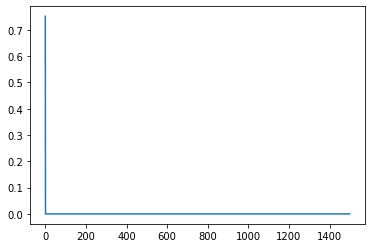

The model accuracy improved from:  0 to:  0.7516162991523743
-------------------------------------------------------------------------
Epoch 2 / 1500 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 62s 35ms/step - loss: 0.5254 - acc: 0.8869
Validation: 
208/208 [==============================] - 8s 37ms/step - loss: 1.3612 - acc: 0.7384


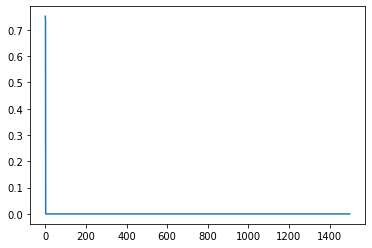

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 3 / 1500 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 65s 37ms/step - loss: 0.5104 - acc: 0.8906
Validation: 
208/208 [==============================] - 8s 38ms/step - loss: 1.3657 - acc: 0.7452


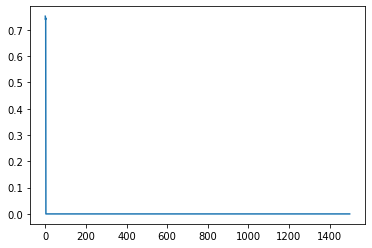

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 4 / 1500 : 
Training: 
Epoch 4/4
 190/1769 [==>...........................] - ETA: 31s - loss: 0.4623 - acc: 0.9020

KeyboardInterrupt: 

In [62]:
model.summary()
training_history = np.zeros(shape=(2,epochs))
validation_history = np.zeros(shape=(2,epochs))
test_history = [0,0]
#print(model.metrics_names)
felix_fit_new(model, batch_size, epochs, CPUworkers, [EarlyStop, Checkpoint], AllPaths, "npy", training_history, validation_history, TrainingPatience, test_history, "acc")

In [16]:
v= val_hist
v[v==0] = np.nan
v= np.nanmean(v, axis=0)
for i in v:
    print(i)
print(v)
print(james_hist)

[485.37855021 421.38844808 282.43925985 ...          nan          nan
          nan]
[[485.37855021 421.38844808 282.43925985 ...          nan          nan
           nan]]
[[153.78343989 169.92783608]
 [153.78343989 169.92783608]
 [153.78343989 169.92783608]]


/home/ug-ml/felix-ML/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
vae = models.load_model("/home/ug-ml/felix-ML/VAE_000/Data/Models/V3/VAE_Reduced_J1_V1")